# Venta de Viviendas en Seattle; Introducción, EDA & Minería de Datos.

## Introducción
El objetivo de este trabajo es explorar un dataset sobre la venta de viviendas en Seattle durante el periodo comprendido entre mayo de 2014 y mayo de 2015 con el objetitvo final de predecir el precio de dichas viviendas con una serie de variables predictoras que ofrece el dataset. Este dataset proviene del módulo de Minería de Datos y Modelización Predictiva del Máster de la Universidad Complutense de Madrid en Big Data, Ciencia de Datos y Business Analytics, y se utiliza en su propio marco de estudio añadiendo nociones de Machine Learning.

El análisis incluye la preparación de los datos, su exploración y posterior construcción de modelos para predecir el precio de las viviendas. Se ha trabajado con un conjunto de variables que describen las características de las propiedades y su entorno. Ver archivo data/'Doc_HousingSales_Regression.pdf'.

Se llevarán a cabo diversas técnicas en minería de datos para abordar los errores, incoherencias y anomalías que presentan los datos a depurar, para posteriormente proponer el mejor modelo predictivo adecuado para capturar las relaciones entre las variables explicativas y la variable objetivo 'precio'.

Sin embargo, esto nos plantea una cuestión importante (dentro de la simplicidad de las dimensiones del dataset de estudio): ¿qué tipo de modelo sería más adecuado para capturar un fenómeno como el precio de las viviendas? ¿Es suficiente emplear un modelo lineal, o deberíamos explorar alternativas más avanzadas que consideren posibles relaciones no lineales y efectos más intrincados entre las variables? Estas preguntas serán clave para reflexionar sobre el enfoque adoptado y los posibles caminos a seguir en futuros análisis.

## EDA & Minería de Datos
### Lectura e inspección de datos

Importamos y cargamos las librerías necesarias para trabajar.

In [1]:
# Procesamiento y visualizacion de datos.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EDA y minería de datos
from feature_engine.outliers import OutlierTrimmer
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import BoxCoxTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from optbinning import ContinuousOptimalBinning

# Otras
import sys
import os
import warnings
warnings.filterwarnings('ignore')

Definamos también un par de funciones que nos ayudará con la visualización de las variables.

In [2]:
def num_graph(df):
    for i in df:
        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}, figsize=(8, 5))   

        sns.boxplot(x=df[i], ax=ax_box, color='blue')
        ax_box.set(title=f"Distribución de '{df[i].name}'", xlabel='')

        sns.histplot(df[i], ax=ax_hist, bins=50, kde=True, color='blue')
        ax_hist.axvline(np.mean(df[i]), color='red', linestyle='-')
        ax_hist.axvline(np.median(df[i]), color='orange', linestyle='--')

        plt.show()

In [3]:
def cat_graph(df):
    for i in df:
        if df[i].nunique() > 20:
            print(f"La variable {df[i].name} tiene alta cardinalidad. Se decide no representarla.")
        else: 
            mode_value = df[i].mode()[0]

            plt.figure(figsize=(8, 5))

            sns.countplot(x=df[i], color='blue')
            plt.title(f"Gráfico de Barras '{df[i].name}'")
            plt.xticks(rotation=90)
            plt.show()

Cargamos y visualizamos el dataset.

In [4]:
df_Viv = pd.read_csv('C:/Users/jeje9/Projects/Housing Sales Seattle/data/raw_data/housingsales_seattle.csv')

In [5]:
df_Viv

,year,month,price,Luxury,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,basement,yr_built,yr_renovated,lat,long
0,2014,7,653450,1,3,2.5,2070,-1,1.0,0,0,C,1540,1,1980,0,47.5936,-122.013
1,2014,6,710000,1,2,1.5,1640,-1,1.5,0,0,A,1540,1,1916,0,47.6624,-122.325
2,2014,10,780000,1,4,3.5,3720,-1,1.0,0,1,B,3720,0,2007,0,47.3216,-121.940
3,2014,12,795000,1,3,3.5,2260,-1,2.0,0,0,B,1880,1,2003,0,47.6422,-122.361
4,2014,10,399950,0,3,2.0,2050,-1,1.0,0,0,A,1170,1,1960,0,47.7447,-122.328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2015,2,370000,0,2,2.5,1390,1821,2.0,0,0,B,1180,1,2007,0,47.5537,-122.282
4996,2015,1,374950,0,4,2.0,1660,8160,1.0,0,0,B,1660,0,1974,0,47.4483,-122.129
4997,2015,2,234000,0,3,2.0,1480,8475,1.0,0,0,C,1480,0,1968,0,47.3126,-122.361
4998,2015,3,475000,0,3,3.0,2540,18900,1.0,0,0,B,1580,1,1978,0,47.7540,-122.144


In [6]:
df_Viv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          5000 non-null   int64  
 1   month         5000 non-null   int64  
 2   price         5000 non-null   int64  
 3   Luxury        5000 non-null   int64  
 4   bedrooms      5000 non-null   int64  
 5   bathrooms     5000 non-null   float64
 6   sqft_living   5000 non-null   int64  
 7   sqft_lot      5000 non-null   int64  
 8   floors        5000 non-null   float64
 9   waterfront    5000 non-null   int64  
 10  view          5000 non-null   int64  
 11  condition     5000 non-null   object 
 12  sqft_above    5000 non-null   int64  
 13  basement      5000 non-null   int64  
 14  yr_built      5000 non-null   int64  
 15  yr_renovated  5000 non-null   int64  
 16  lat           5000 non-null   float64
 17  long          5000 non-null   float64
dtypes: float64(4), int64(13), ob

Se observa que al menos no hay NAs declarados. Respecto al tipo de cada variable quizás sí deberíamos de hacer cambios.

Mostremos los descriptivos de las variables numéricas, y posteriormente se representarán el gráfico de distribución o de barras según la tipología inicial de cada variable, para tener una primera visión global de cada variable.

In [7]:
df_Viv.describe().round(1)

,year,month,price,Luxury,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,basement,yr_built,yr_renovated,lat,long
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,2014.3,6.6,544129.1,0.4,3.6,2.1,2077.4,13732.5,1.5,-0.0,0.1,1784.9,0.4,1971.1,86.2,47.6,-122.2
std,0.5,3.1,372986.9,0.5,3.7,0.9,916.5,37581.4,0.5,0.2,0.3,824.3,0.5,29.2,405.5,0.1,0.1
min,2014.0,1.0,86500.0,0.0,0.0,0.0,370.0,-1.0,1.0,-1.0,0.0,370.0,0.0,1900.0,0.0,47.2,-122.5
25%,2014.0,4.0,324937.5,0.0,3.0,1.5,1410.0,4500.0,1.0,0.0,0.0,1190.0,0.0,1951.0,0.0,47.5,-122.3
50%,2014.0,6.0,451000.0,0.0,3.0,2.5,1910.0,7312.0,1.5,0.0,0.0,1550.0,0.0,1975.0,0.0,47.6,-122.2
75%,2015.0,9.0,645000.0,1.0,4.0,2.5,2560.0,10284.2,2.0,0.0,0.0,2220.0,1.0,1996.0,0.0,47.7,-122.1
max,2015.0,12.0,7062500.0,1.0,70.0,6.0,10040.0,1164794.0,3.5,1.0,1.0,7680.0,1.0,2015.0,2015.0,47.8,-121.4


In [8]:
num_cols = df_Viv.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_Viv.select_dtypes(include=['category', 'object']).columns

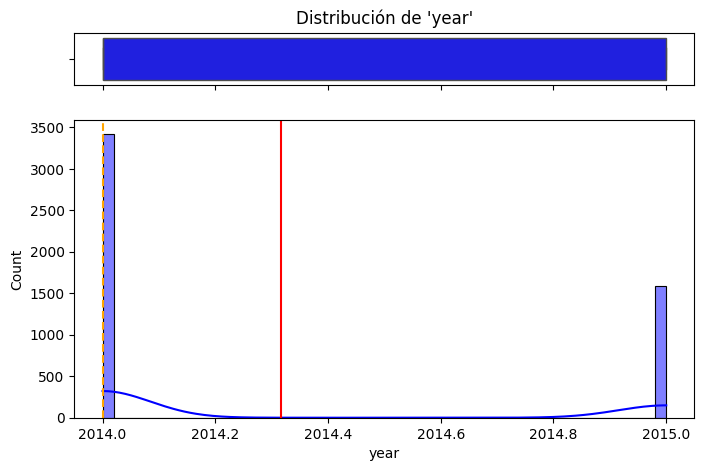

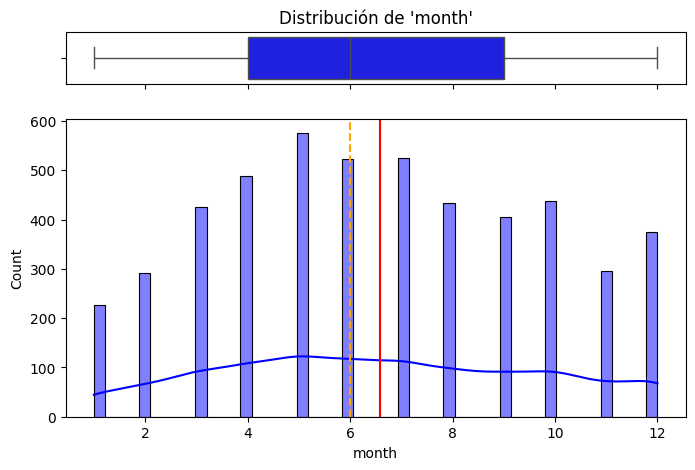

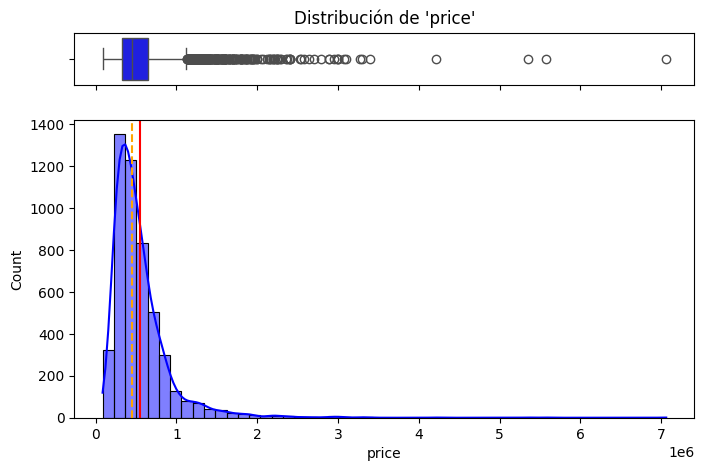

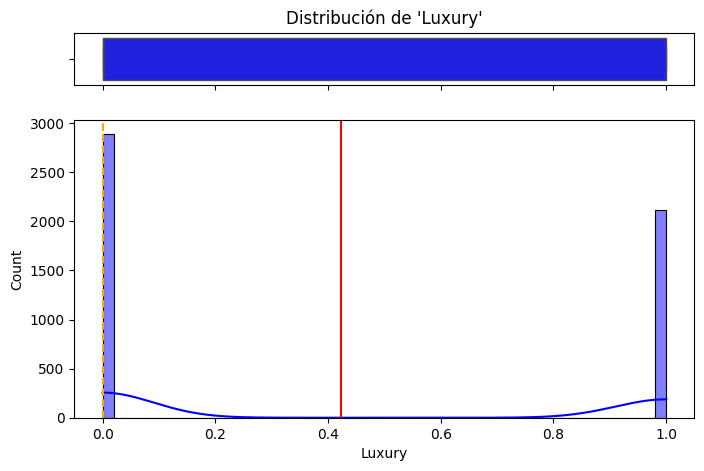

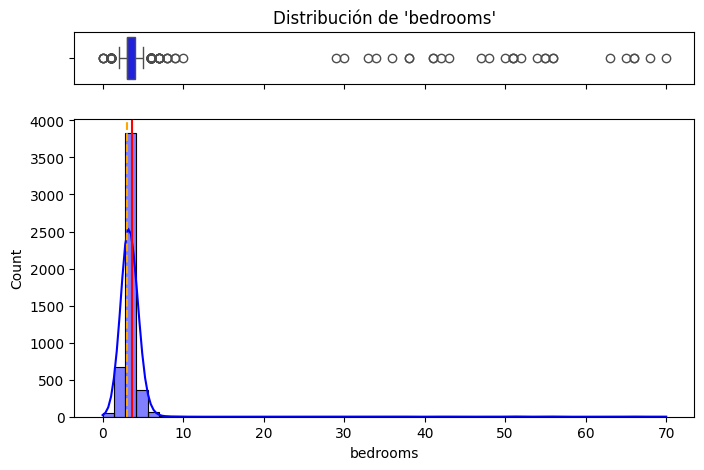

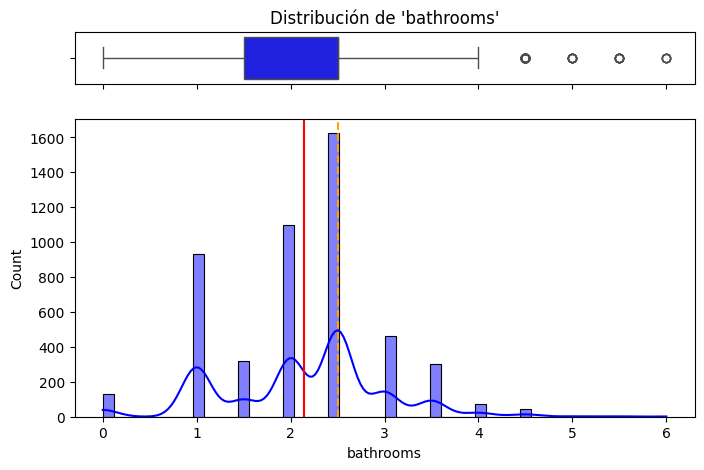

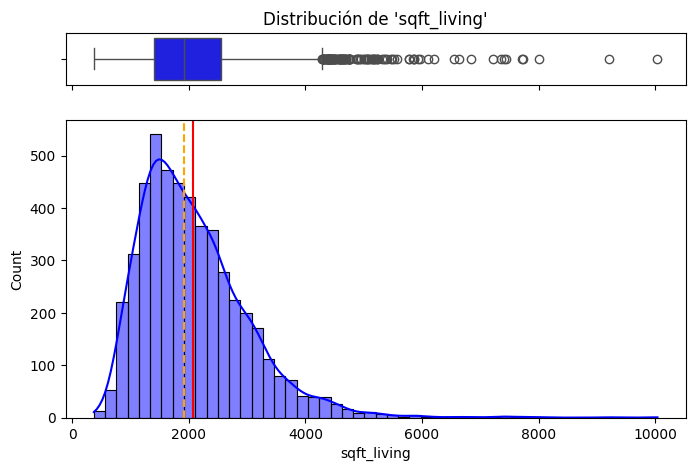

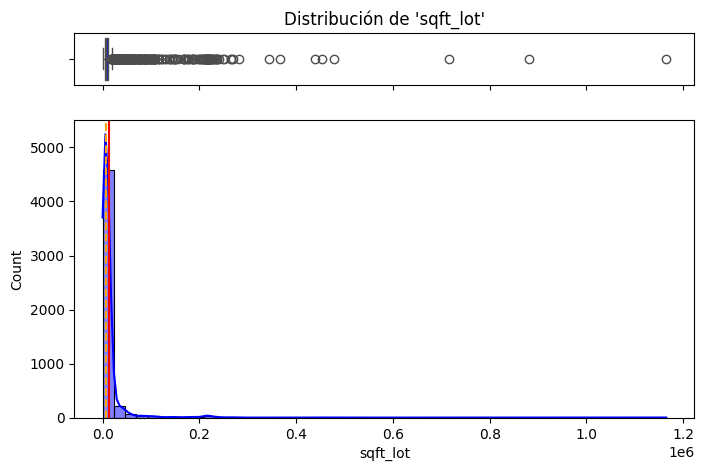

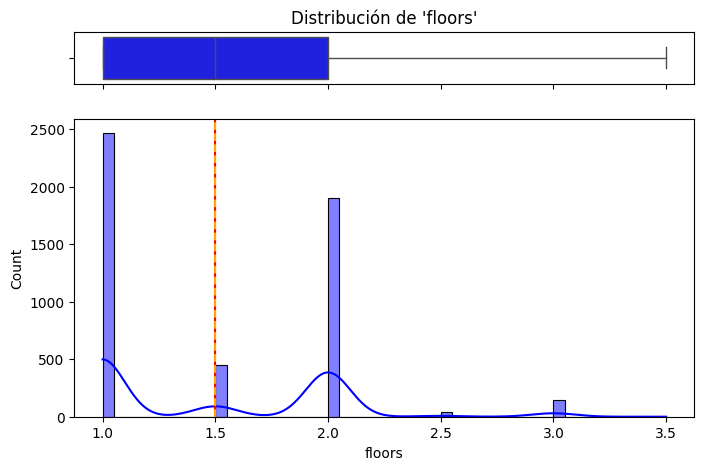

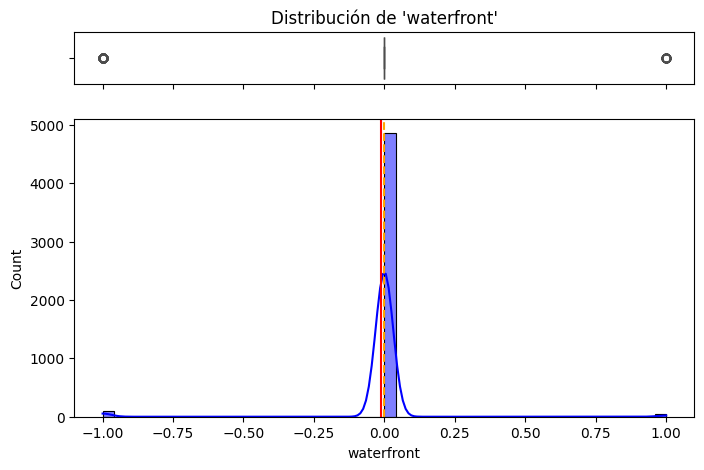

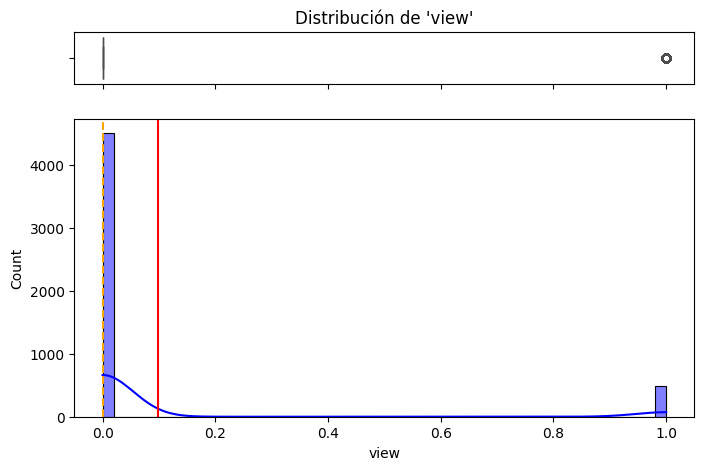

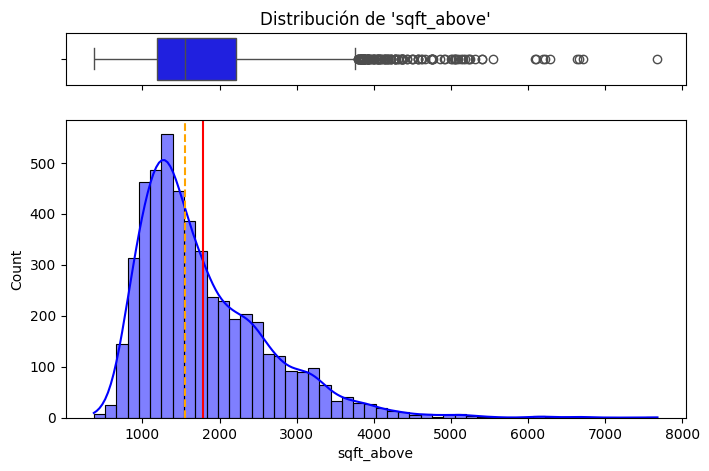

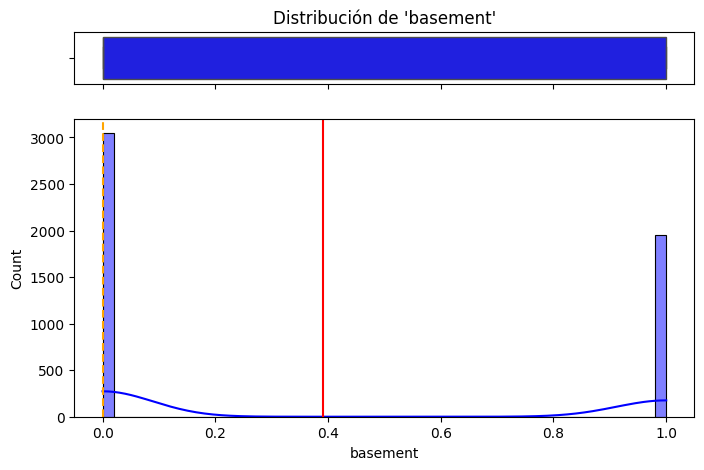

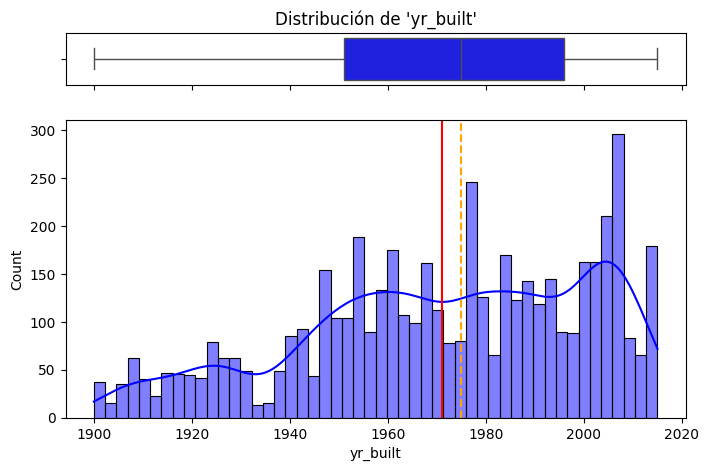

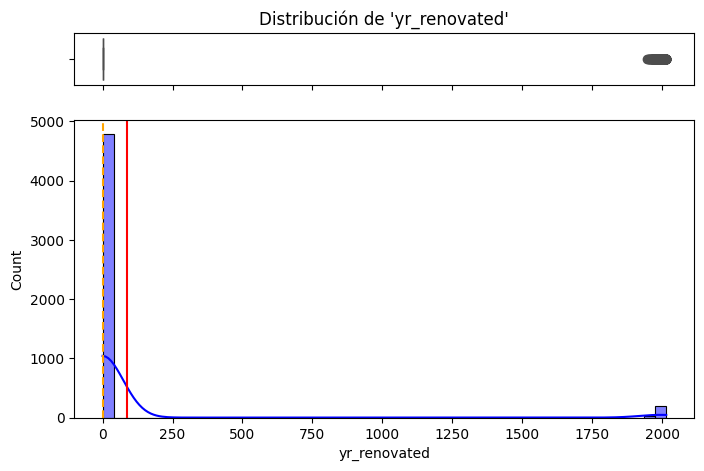

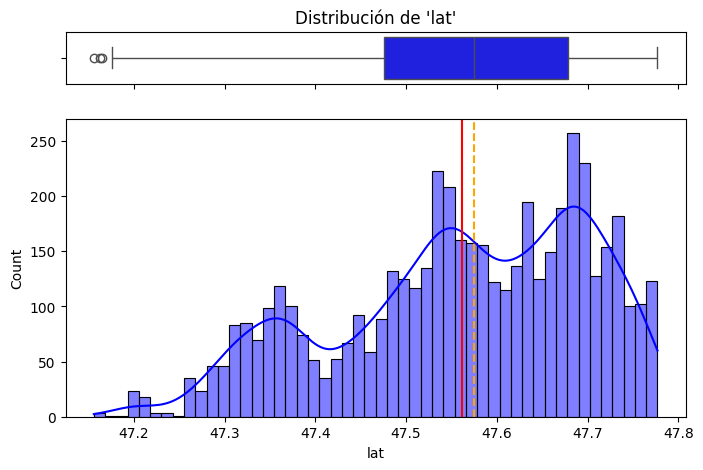

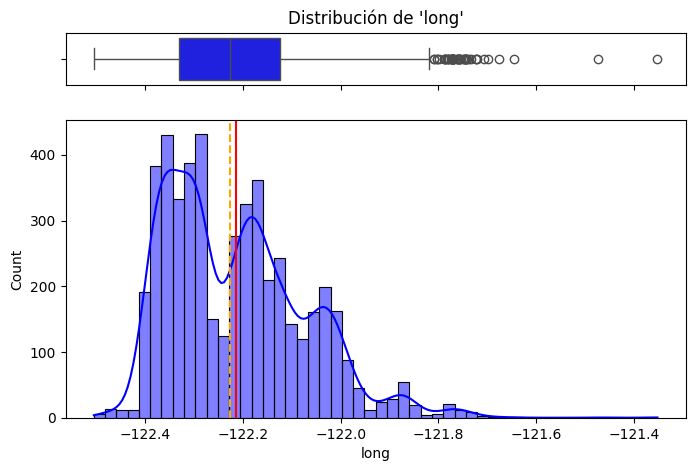

In [9]:
num_graph(df_Viv[num_cols])

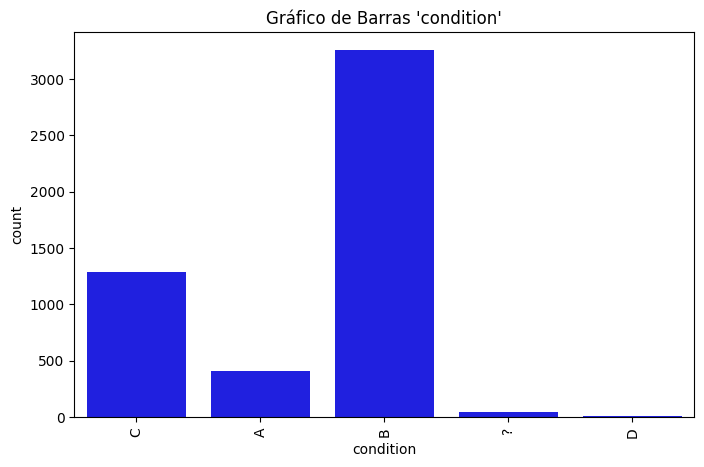

In [10]:
cat_graph(df_Viv[cat_cols])

Lo primero que se aprecia es que parece que sí que hay NAs no declarados en algunas variables, por ello tratemos de etiquetarlos en principio como NAs. También se confirma que se ha de cambiar el tipo de algunas variables y gestionar outliers.

Una buena práctica a realizar también cuando tenemos variables de geolocalización referidas a longitud y latitud, es graficarlas con un gráfico de puntos frente a la variable objetivo, para observar como se comportan en relación y detectar anomalías o patrones en relación a la variable objetivo.

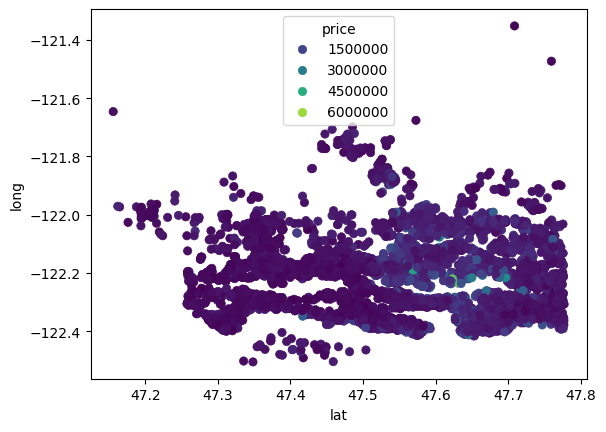

In [11]:
sns.scatterplot(x = df_Viv['lat'], y = df_Viv['long'], hue=df_Viv['price'], palette='viridis', edgecolor=None)
plt.show()

Se realiza la división del dataframe entre variables predictoras y la variable objetivo.

In [12]:
imput = df_Viv.drop(['price'],axis=1)
imput.head()

,year,month,Luxury,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,basement,yr_built,yr_renovated,lat,long
0,2014,7,1,3,2.5,2070,-1,1.0,0,0,C,1540,1,1980,0,47.5936,-122.013
1,2014,6,1,2,1.5,1640,-1,1.5,0,0,A,1540,1,1916,0,47.6624,-122.325
2,2014,10,1,4,3.5,3720,-1,1.0,0,1,B,3720,0,2007,0,47.3216,-121.940
3,2014,12,1,3,3.5,2260,-1,2.0,0,0,B,1880,1,2003,0,47.6422,-122.361
4,2014,10,0,3,2.0,2050,-1,1.0,0,0,A,1170,1,1960,0,47.7447,-122.328


In [13]:
varObj = df_Viv[['price']]

Cambiamos variables a tipo category según la condición dada.

In [14]:
for col in imput.columns:
    if imput[col].nunique() < 13:
        imput[col] = imput[col].astype('category')

Reasignamos columnas numéricas y categóricas según el cambio realizado anterior.

In [15]:
num_cols = imput.select_dtypes(include=['float64', 'int64']).columns
cat_cols = imput.select_dtypes(include=['category', 'object']).columns

### Outliers

Pasemos a la gestión de posibles outliers de nuestras variables continuas, se calcula el coeficiente de asimetría para cada variable.

In [16]:
imput[num_cols].skew()

bedrooms        12.916180
sqft_living      1.404513
sqft_lot        13.051348
sqft_above       1.414411
yr_built        -0.465003
yr_renovated     4.495506
lat             -0.511038
long             0.796275
dtype: float64

La mayoría de variables presentan una asimetría importante por la derecha, esto es algo que se debería de corregir con la gestión de outliers y realizando sus respectivas transformaciones.

Procedemos a la gestión de outliers mediante el método winsor de la librería feature_engine, para ello, previamente debemos de asegurarnos que todas las variables numéricas son válidas para dicho método.

In [17]:
valid_cols = []
for i in num_cols:
    Q1 = imput[i].quantile(0.25)
    Q3 = imput[i].quantile(0.75)
    if (Q3 - Q1) > 0:
        valid_cols.append(i)
    else:
        print(i)

yr_renovated


Estas variables han de cumplir que bajo el método de winsorización por rango intercuartílico, la diferencia entre el tercer y primer cuartil ha de ser no nula, esto es debido a que la gestión de outliers con feature_engine es sensible a variables con baja o nula varianza. Estas variables no validas obtenidas tienen indicios para aplicar otras transformaciones más adecuadas debido a lo anteriormente mencionado.

Prescindimos de las variables lat y long para la gestión de sus outliers.

In [18]:
valid_cols = [i for i in valid_cols if i not in ['lat', 'long']]

valid_cols

['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'yr_built']

Denotamos outliers algo permisivos a 3 veces el rango intercuartílico más allá de cada cuartil.

In [19]:
trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=3, variables=valid_cols)

trimmer.fit(imput)

OutlierTrimmer(capping_method='iqr', fold=3, tail='both',
               variables=['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
                          'yr_built'])

Winsorizamos a cada extremo.

In [20]:
winsor = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=valid_cols)

In [21]:
winsor.fit(imput)

imput_winsorized = winsor.transform(imput)

Visualizamos las nuevas variables winsorizadas.

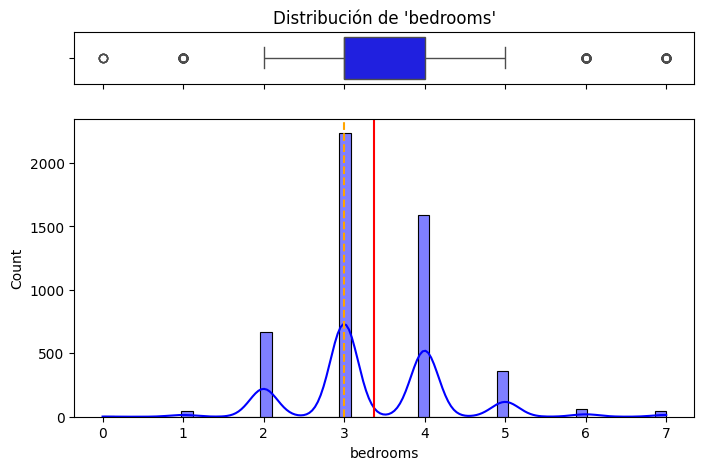

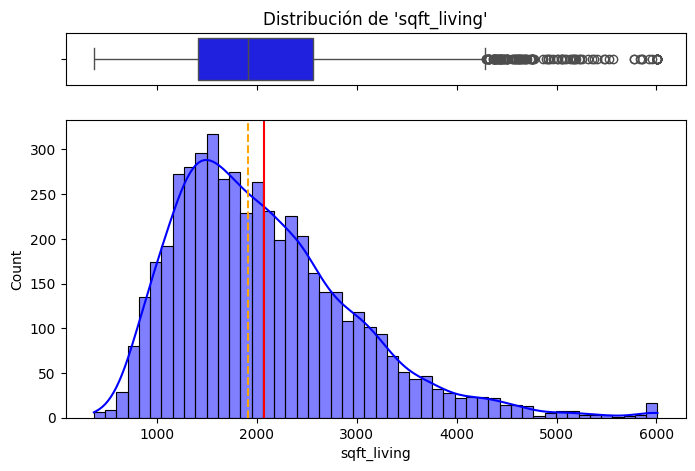

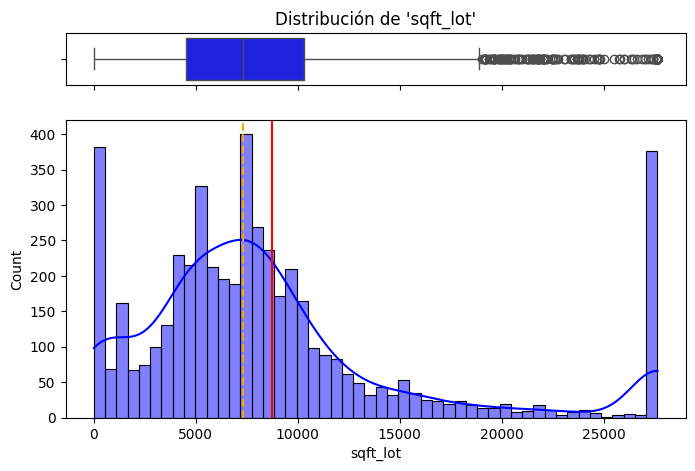

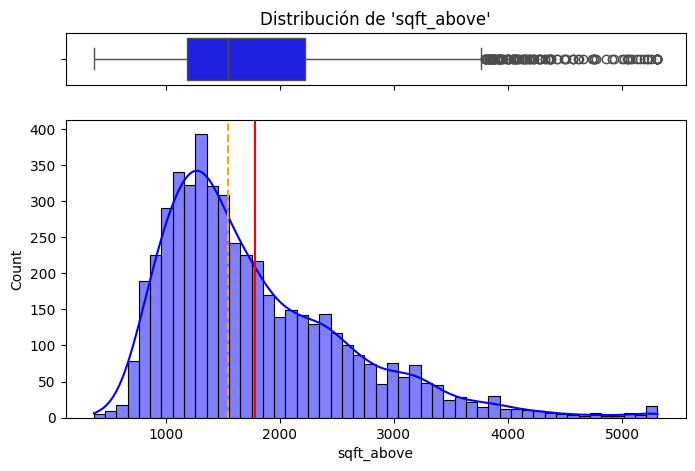

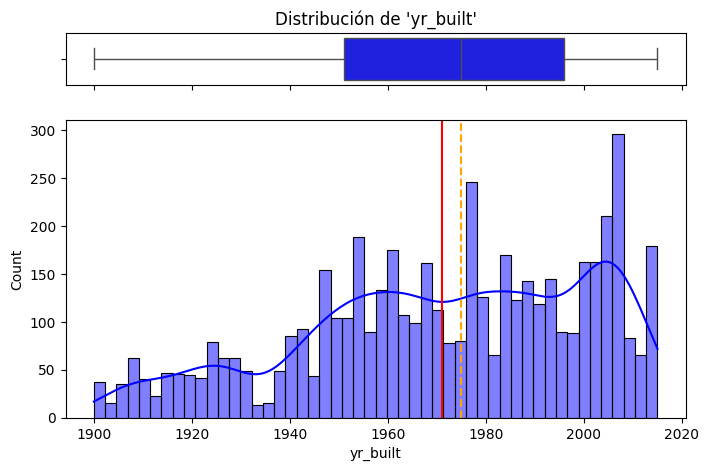

In [22]:
num_graph(imput_winsorized[valid_cols])

Muy sobrecargada la variable sqft_lot en la cola derecha de la distribución. Se podría dejar sin gestionar los outliers de dicha varible, y aplicar la tranformación directamente, o primero tranformarla y luego gestionar outliers.

In [23]:
imput[valid_cols] = imput_winsorized[valid_cols]

In [24]:
imput.to_csv('../data/freeze_data/df_wins.csv', index=False)

### NAs

Asignamos NAs a los valores de las variables que no son posibles según su respectiva naturaleza. A estos valores se les denomina NAs no declarados.

In [25]:
imput.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          5000 non-null   category
 1   month         5000 non-null   category
 2   Luxury        5000 non-null   category
 3   bedrooms      5000 non-null   int64   
 4   bathrooms     5000 non-null   category
 5   sqft_living   5000 non-null   int64   
 6   sqft_lot      5000 non-null   int64   
 7   floors        5000 non-null   category
 8   waterfront    5000 non-null   category
 9   view          5000 non-null   category
 10  condition     5000 non-null   category
 11  sqft_above    5000 non-null   int64   
 12  basement      5000 non-null   category
 13  yr_built      5000 non-null   int64   
 14  yr_renovated  5000 non-null   int64   
 15  lat           5000 non-null   float64 
 16  long          5000 non-null   float64 
dtypes: category(9), float64(2), int64(6)
memory usage: 3

In [26]:
imput.loc[imput['sqft_lot'] == -1, 'sqft_lot'] = np.nan
imput.loc[imput['waterfront'] == -1, 'waterfront'] = np.nan

Para imputar los NAs de estas variables se realizarán mediante dos métodos de imputación distintos: K-Nearest Neighbors para sqft_lot y una imputación simple por la moda para waterfront.

#### Imputación Simple mediante Moda.

In [27]:
imputer = SimpleImputer(strategy='most_frequent')

In [28]:
imput[['waterfront']] = imputer.fit_transform(imput[['waterfront']])

In [29]:
imput["waterfront"] = imput["waterfront"].astype(int)
imput["waterfront"] = imput["waterfront"].astype("category")

#### Imputación mediante K-Nearest Neighbors.

Para la variable 'sqft_lot', se utiliza la imputación basada en vecinos cercanos K-Nearest Neighbors, este método de imputación utiliza los valores de los registros más cercanos para estimar los valores faltantes, en este caso como tenemos una variable continua de la cual estimar sus NAs, se calcula el promedio de los valores de los vecinos más cercanos.

In [30]:
imput_cont = imput.select_dtypes(include=['float64', 'int64']).columns
imput_cat = imput.select_dtypes(include=['category', 'object']).columns

Aplicamos escalado de datos MinMax Scaler para que todas se encuentren en el mismo rango de 0 a 1, así todas tienen la misma importancia en la imputación.

In [31]:
scaler = MinMaxScaler()
imput[imput_cont] = scaler.fit_transform(imput[imput_cont])

Codificamos con Label Encoder las variables categóricas para posteriormente realizar la imputación KNN.

In [32]:
le = LabelEncoder()
encoders = {}

for i in imput_cat:
    le = LabelEncoder()
    imput[i] = le.fit_transform(imput[i])
    encoders[i] = le

Aplicamos la imputación, y convertimos el array de numpy devuelto a un dataframe.

In [33]:
imputer_knn = KNNImputer(n_neighbors=5)
imputed= imputer_knn.fit_transform(imput)

In [34]:
df_imputed = pd.DataFrame(imputed, columns=imput.columns)

Revertimos Scaler y Encoder.

In [35]:
imput[imput_cont] = scaler.inverse_transform(df_imputed[imput_cont])

In [36]:
for i in imput_cat:
    le = encoders[i]
    imput[i] = le.inverse_transform(df_imputed[i].astype(int))

In [37]:
imput['waterfront'] = imput['waterfront'].astype('category')

Visualizamos el dataframe original con la nueva imputación.

In [38]:
df_imputed = pd.concat([imput, varObj], axis=1)

In [39]:
df_imputed

,year,month,Luxury,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,basement,yr_built,yr_renovated,lat,long,price
0,2014,7,1,3.0,2.5,2070.0,12624.0,1.0,0,0,C,1540.0,1,1980.0,0.0,47.5936,-122.013,653450
1,2014,6,1,2.0,1.5,1640.0,4091.4,1.5,0,0,A,1540.0,1,1916.0,0.0,47.6624,-122.325,710000
2,2014,10,1,4.0,3.5,3720.0,8421.8,1.0,0,1,B,3720.0,0,2007.0,0.0,47.3216,-121.940,780000
3,2014,12,1,3.0,3.5,2260.0,4079.8,2.0,0,0,B,1880.0,1,2003.0,0.0,47.6422,-122.361,795000
4,2014,10,0,3.0,2.0,2050.0,8873.0,1.0,0,0,A,1170.0,1,1960.0,0.0,47.7447,-122.328,399950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2015,2,0,2.0,2.5,1390.0,1821.0,2.0,0,0,B,1180.0,1,2007.0,0.0,47.5537,-122.282,370000
4996,2015,1,0,4.0,2.0,1660.0,8160.0,1.0,0,0,B,1660.0,0,1974.0,0.0,47.4483,-122.129,374950
4997,2015,2,0,3.0,2.0,1480.0,8475.0,1.0,0,0,C,1480.0,0,1968.0,0.0,47.3126,-122.361,234000
4998,2015,3,0,3.0,3.0,2540.0,18900.0,1.0,0,0,B,1580.0,1,1978.0,0.0,47.7540,-122.144,475000


In [40]:
df_imputed.to_csv('../data/freeze_data/df_imputed.csv', index=False)

### Transformación de Variables

#### Transformación de Continuas

In [41]:
df_imputed_trf = df_imputed.copy()

In [42]:
df_imputed_trf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          5000 non-null   int64   
 1   month         5000 non-null   int64   
 2   Luxury        5000 non-null   int64   
 3   bedrooms      5000 non-null   float64 
 4   bathrooms     5000 non-null   float64 
 5   sqft_living   5000 non-null   float64 
 6   sqft_lot      5000 non-null   float64 
 7   floors        5000 non-null   float64 
 8   waterfront    5000 non-null   category
 9   view          5000 non-null   int64   
 10  condition     5000 non-null   object  
 11  sqft_above    5000 non-null   float64 
 12  basement      5000 non-null   int64   
 13  yr_built      5000 non-null   float64 
 14  yr_renovated  5000 non-null   float64 
 15  lat           5000 non-null   float64 
 16  long          5000 non-null   float64 
 17  price         5000 non-null   int64   
dtypes: categ

Primero, se debe de estudiar si es conveniente transformar la variable objetivo.

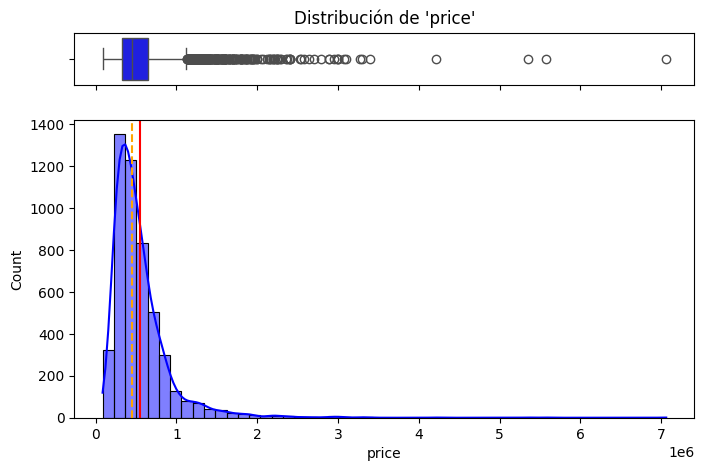

In [43]:
objetivo = 'price'

num_graph(df_imputed_trf[[objetivo]])

Se observa que tiene asimetría por la derecha (sesgo positivo), se decide aplicarle una tranformación Box-Cox, puesto que el modelo de regresión a realizar posteriormente, es sensible a la normalidad de la variable objetivo.

In [44]:
boxcox = BoxCoxTransformer(variables=objetivo)

In [45]:
df_imputed_trf = boxcox.fit_transform(df_imputed_trf)

print(boxcox.lambda_dict_)

{'price': np.float64(-0.24422525190625913)}


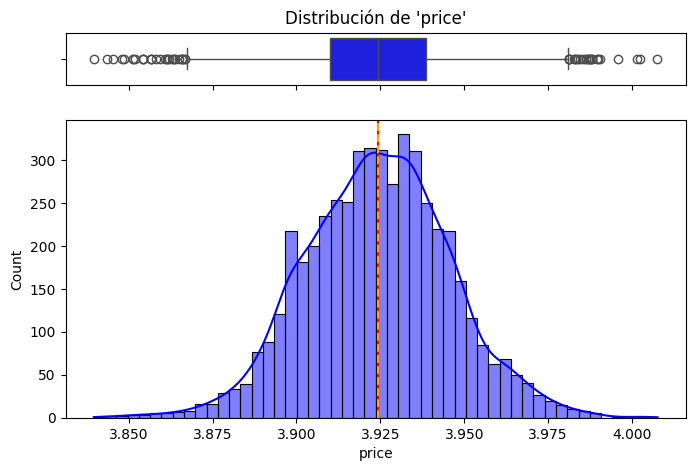

In [46]:
num_graph(df_imputed_trf[[objetivo]])

A continuación, se evaluará la mejor transformación para las variables continuas predictoras en función de la distribución de cada variable continua y la relación frente a la variable objetivo, o si de lo contrario, mejor aplicar un binning a la variable y categorizarla. Para ello nos ayudamos de un scatter plot para valorar la relación de cada variable numérica frente a la objetivo.

In [47]:
predictoras_cont = df_imputed_trf.select_dtypes(include='number').columns.tolist()
#predictoras_cont = [i for i in predictoras_cont if i != objetivo]

In [48]:
predictoras_cont

['year',
 'month',
 'Luxury',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'sqft_above',
 'basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'price']

In [49]:
def scatt_graph(df, obj):
    for i in df:
        if i != obj:
            sns.scatterplot(x=i, y=obj, data=df, alpha=0.5)
            plt.title(f'Scatter plot: {i} vs {obj}')
            plt.xlabel(i)
            plt.ylabel(obj)

            plt.show()

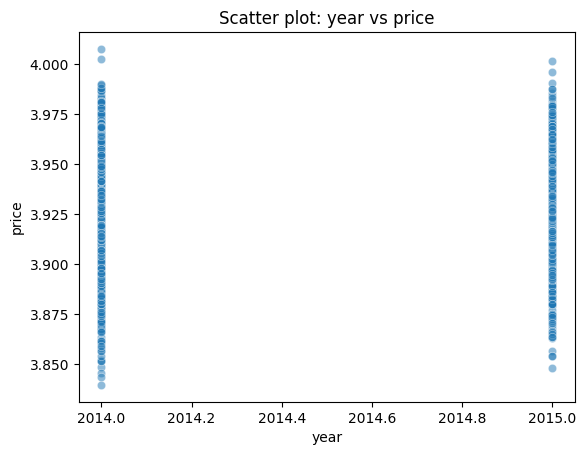

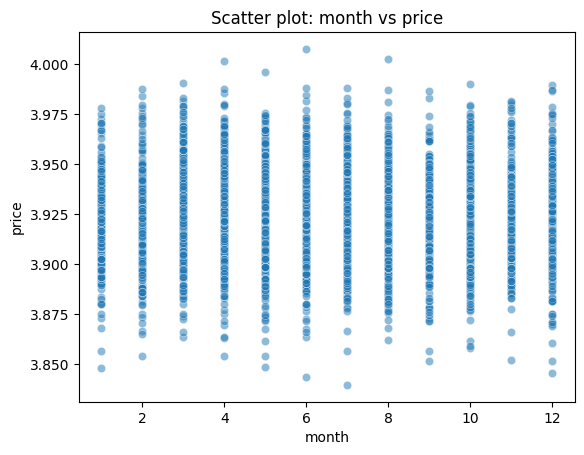

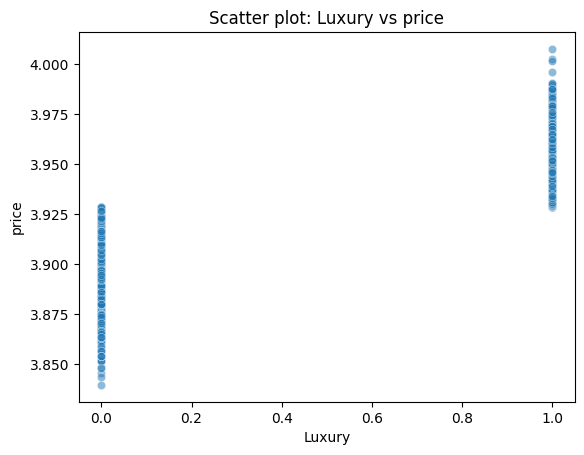

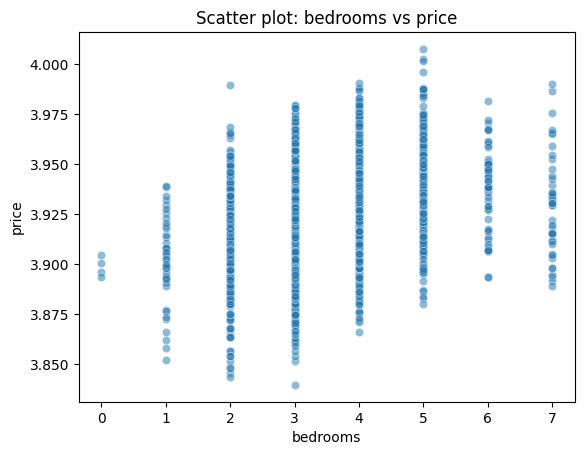

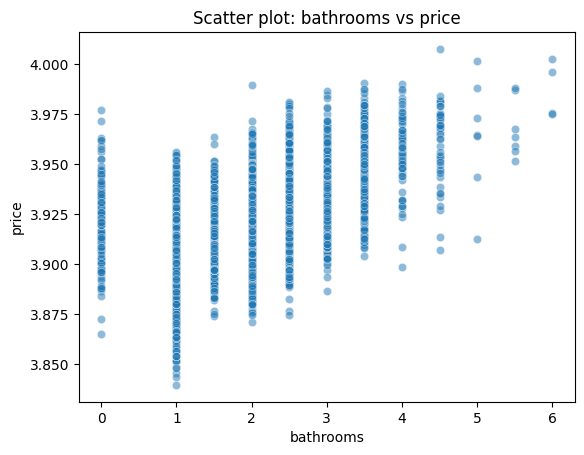

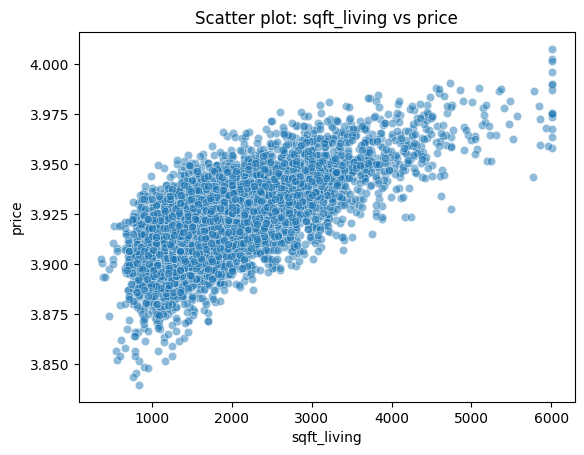

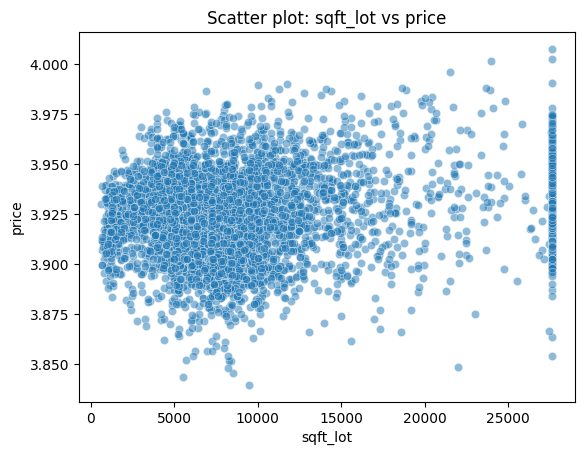

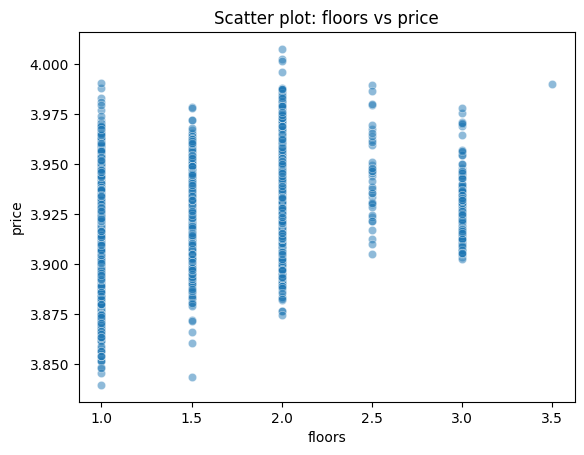

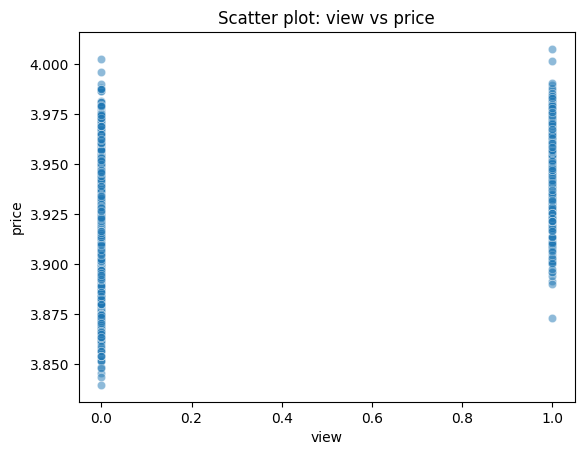

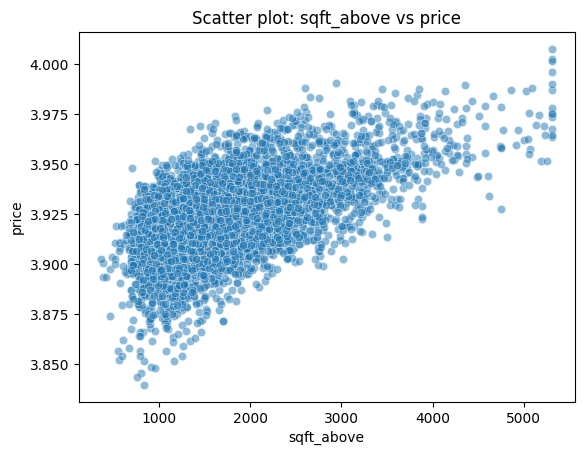

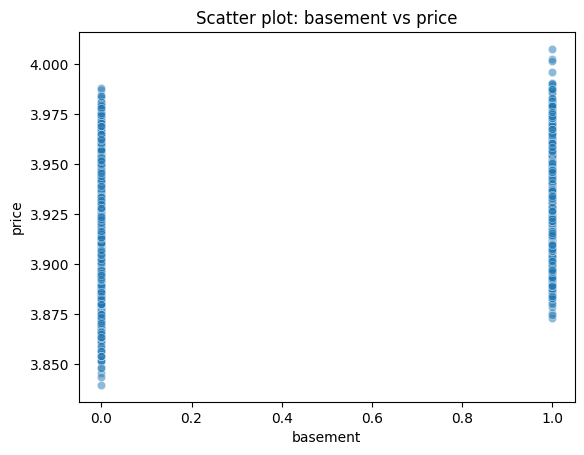

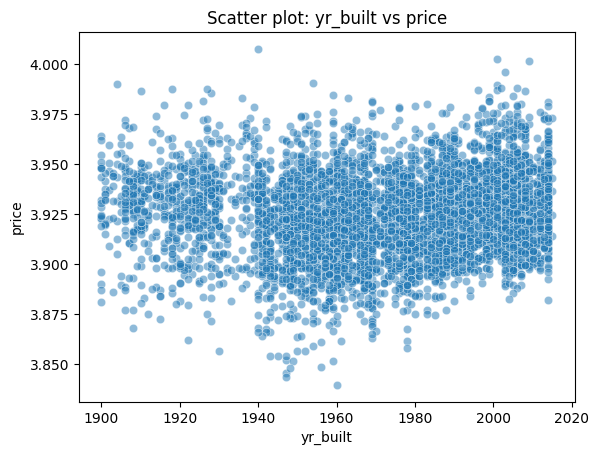

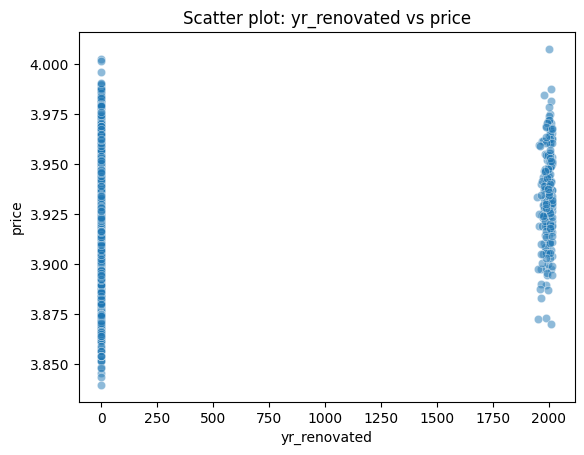

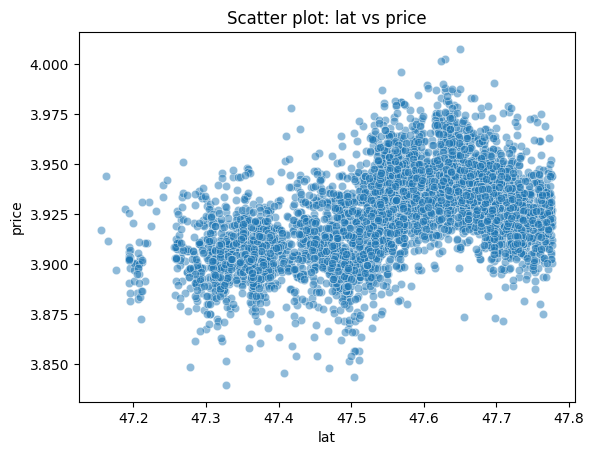

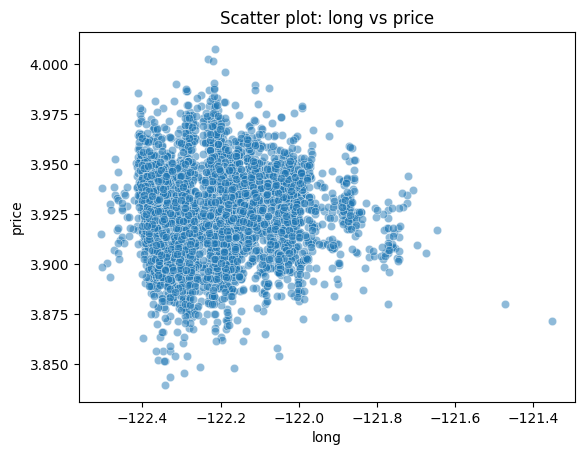

In [50]:
scatt_graph(df_imputed_trf[predictoras_cont], objetivo)

Podemos considerar year como metadato, puesto que solo tiene dos valores, y no aporta nada a la variable objetivo, además de su naturaleza por sí misma en el dataset.

In [51]:
df_imputed_trf = df_imputed_trf.drop(columns = 'year')

In [52]:
predictoras_cont = [i for i in predictoras_cont if i != 'year']

Algunas variables numéricas les aplicaremos una transformación según proceda, al resto se le aplicará un binning y se pasarán a categóricas.

A lat y long se decide no aplicarle ninguna transformación, sqft_living, sqft_lot y sqft_above se transforman según box-cox.

In [53]:
boxcox = BoxCoxTransformer(variables=['sqft_living', 'sqft_lot', 'sqft_above'])

df_imputed_trf = boxcox.fit_transform(df_imputed_trf)

A yr_renovated se le aplica un categorización manual para dos categorías.

In [54]:
df_imputed_trf['yr_renovated'] = df_imputed_trf['yr_renovated'].astype('int')

df_imputed_trf['renovated'] = np.where(df_imputed_trf['yr_renovated'] != 0, 1, 0)
df_imputed_trf['renovated'] = df_imputed_trf['renovated'].astype('category')

df_imputed_trf = df_imputed_trf.drop(columns = ['yr_renovated'])

Por último, las siguientes variables las categorizamos con OptimalBinning, con esto se realiza un binning supervisado que encuentra los mejores cortes de cada variable para maximizar la separación respecto a la variable objetivo, creando así intervalos que explican mejor las diferencias en price.

In [55]:
var_bins = ['bedrooms', 'floors', 'bathrooms', 'yr_built', 'month']

In [56]:
for i in var_bins:
    optb = ContinuousOptimalBinning(name=i, dtype="numerical", max_n_bins=5)
    optb.fit(df_imputed_trf[i].values, df_imputed_trf[objetivo])

    x_transform_bins = optb.transform(df_imputed_trf[i].values, metric="bins")
    x_transform_bins

    df_imputed_trf[i] = x_transform_bins
    df_imputed_trf[i] = df_imputed_trf[i].astype('category')

#### Transformación de Categóricas

Visualizamos las variables categóricas que tenemos en nuestro dataframe con los binning realizados.

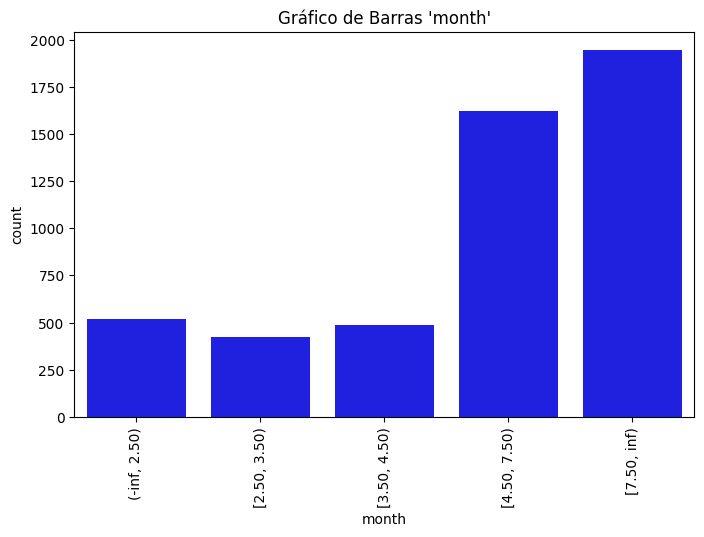

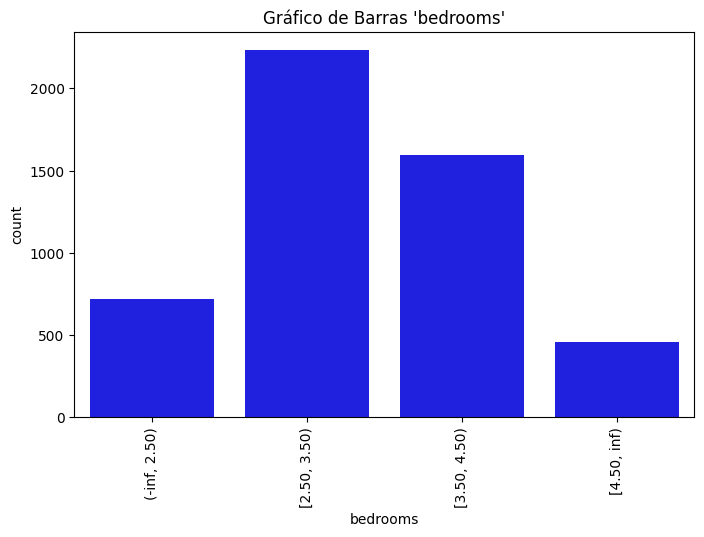

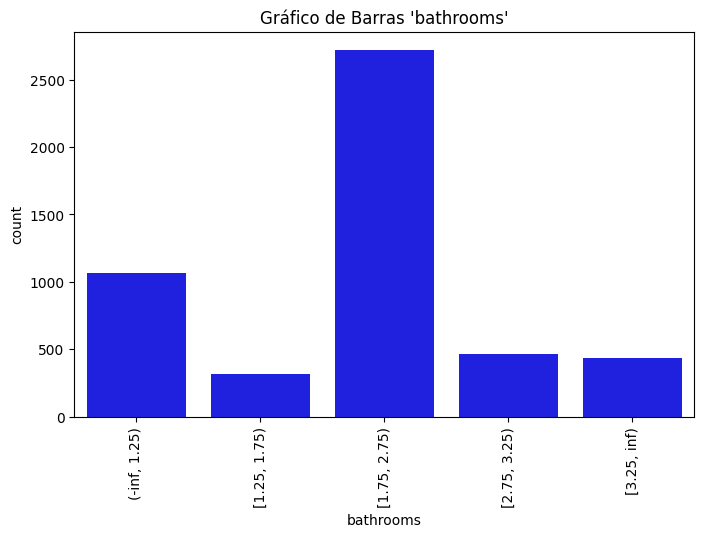

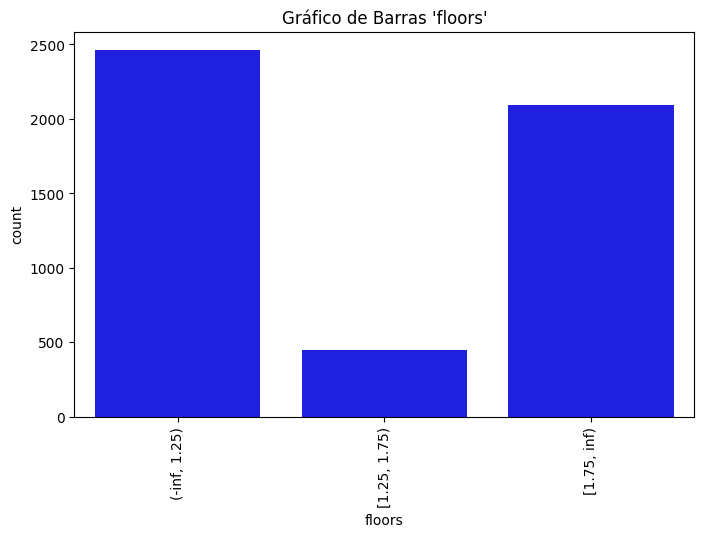

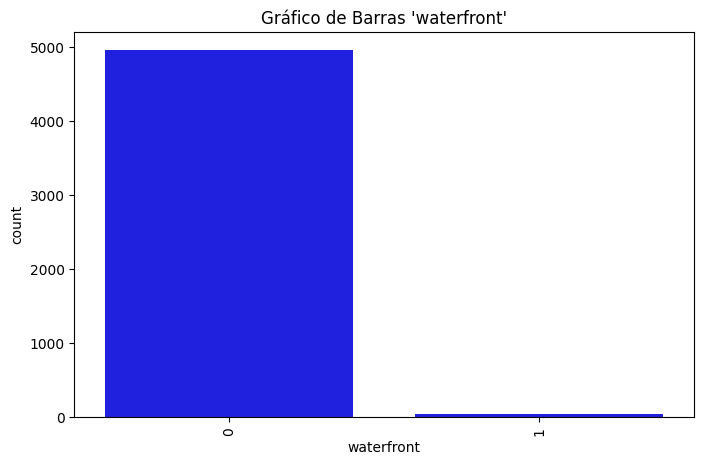

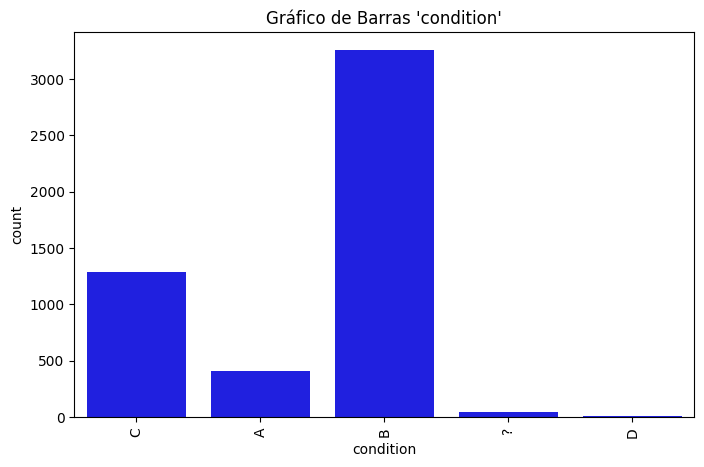

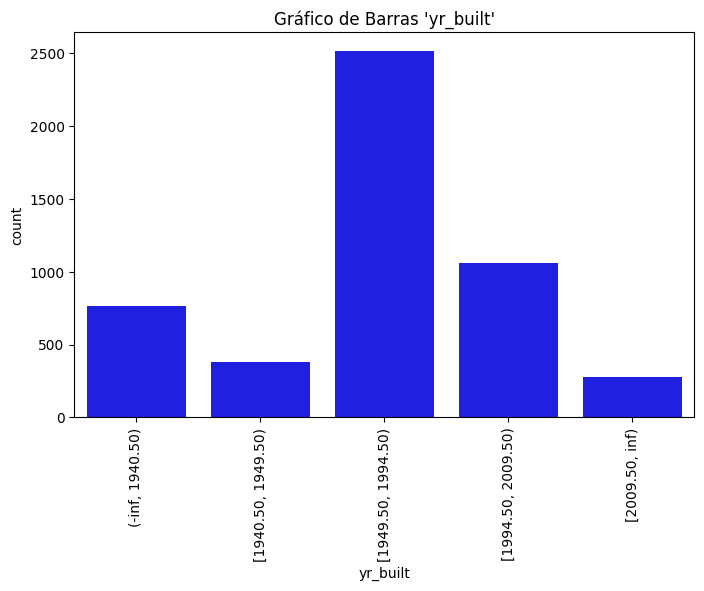

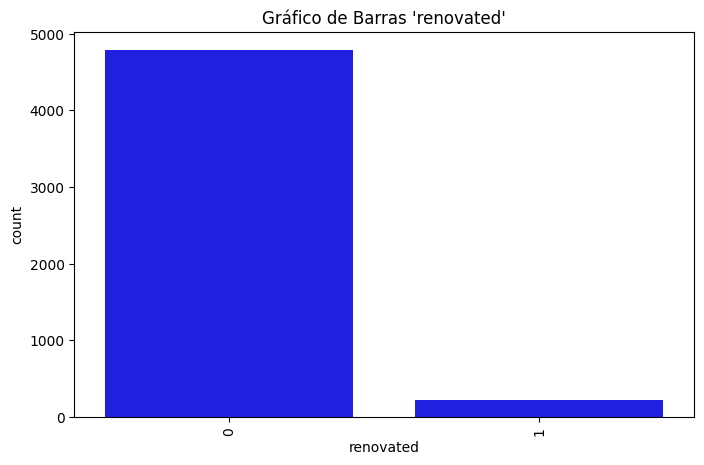

In [57]:
cat_cols = df_imputed_trf.select_dtypes(include=['category', 'object'])

cat_graph(cat_cols)

#### Feature Enginering

Por último, hagamos un poco de eso de feature enginering sobre nuestras variables lat y long partiendo del scatter plot en relación a la variable objetivo price que hicimos al principio del notebook.

La idea es crear una nueva variable resultante de la distancia euclidea de cada punto lat y long de nuestro dataset a un punto que minimiza la distancia ponderada por price a todos los puntos del dataset. Para ello, primero creamos las matrices de puntos para el cálculo.

In [58]:
coords = df_Viv[['lat', 'long']].to_numpy()
weights = df_Viv['price'].to_numpy()

In [59]:
center = np.average(coords, axis=0, weights=weights)

In [60]:
dists = np.linalg.norm(coords - center, axis=1)
df_imputed_trf['dist_to_center'] = dists

In [61]:
df_imputed_trf['dist_to_center']

0       0.199957
1       0.133557
2       0.382622
3       0.157088
4       0.192996
          ...   
4995    0.077928
4996    0.164486
4997    0.314244
4998    0.178108
4999    0.031752
Name: dist_to_center, Length: 5000, dtype: float64

Debido a las pocas categorías 'D' y '?' en la variable condition, las transformamos a 'B' y 'C' respectivamente.

In [62]:
df_imputed_trf['condition'] = df_imputed_trf['condition'].replace({'?': 'B', 'D': 'C'})

Observamos nuestro dataset final.

In [63]:
columnas_ordenadas = ['month', 'Luxury', 'floors', 'bedrooms', 'bathrooms', 'basement', 'view', 'waterfront', 'condition', 'sqft_lot', 'sqft_living', 'sqft_above', 'yr_built', 'renovated', 'lat', 'long', 'dist_to_center', 'price']

df_imputed_trf = df_imputed_trf[columnas_ordenadas]
df_imputed_trf

,month,Luxury,floors,bedrooms,bathrooms,basement,view,waterfront,condition,sqft_lot,sqft_living,sqft_above,yr_built,renovated,lat,long,dist_to_center,price
0,"[4.50, 7.50)",1,"(-inf, 1.25)","[2.50, 3.50)","[1.75, 2.75)",1,0,0,C,25.526560,10.462583,3.831498,"[1949.50, 1994.50)",0,47.5936,-122.013,0.199957,3.938989
1,"[4.50, 7.50)",1,"[1.25, 1.75)","(-inf, 2.50)","[1.25, 1.75)",1,0,0,A,19.718707,10.042106,3.831498,"(-inf, 1940.50)",0,47.6624,-122.325,0.133557,3.942111
2,"[7.50, inf)",1,"(-inf, 1.25)","[3.50, 4.50)","[3.25, inf)",0,1,0,B,23.299890,11.555784,4.015587,"[1994.50, 2009.50)",0,47.3216,-121.940,0.382622,3.945572
3,"[7.50, inf)",1,"[1.75, inf)","[2.50, 3.50)","[3.25, inf)",1,0,0,B,19.705543,10.623168,3.876046,"[1994.50, 2009.50)",0,47.6422,-122.361,0.157088,3.946264
4,"[7.50, inf)",0,"(-inf, 1.25)","[2.50, 3.50)","[1.75, 2.75)",1,0,0,A,23.577734,10.444897,3.767129,"[1949.50, 1994.50)",0,47.7447,-122.328,0.192996,3.919169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"(-inf, 2.50)",0,"[1.75, inf)","(-inf, 2.50)","[1.75, 2.75)",1,0,0,B,16.231463,9.748085,3.769177,"[1994.50, 2009.50)",0,47.5537,-122.282,0.077928,3.915803
4996,"(-inf, 2.50)",0,"(-inf, 1.25)","[3.50, 4.50)","[1.75, 2.75)",0,0,0,B,23.133064,10.063805,3.848465,"[1949.50, 1994.50)",0,47.4483,-122.129,0.164486,3.916382
4997,"(-inf, 2.50)",0,"(-inf, 1.25)","[2.50, 3.50)","[1.75, 2.75)",0,0,0,C,23.333273,9.859166,3.822408,"[1949.50, 1994.50)",0,47.3126,-122.361,0.314244,3.894635
4998,"[2.50, 3.50)",0,"(-inf, 1.25)","[2.50, 3.50)","[2.75, 3.25)",1,0,0,B,27.918393,10.838477,3.837325,"[1949.50, 1994.50)",0,47.7540,-122.144,0.178108,3.926384


In [64]:
df_imputed_trf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   month           5000 non-null   category
 1   Luxury          5000 non-null   int64   
 2   floors          5000 non-null   category
 3   bedrooms        5000 non-null   category
 4   bathrooms       5000 non-null   category
 5   basement        5000 non-null   int64   
 6   view            5000 non-null   int64   
 7   waterfront      5000 non-null   category
 8   condition       5000 non-null   object  
 9   sqft_lot        5000 non-null   float64 
 10  sqft_living     5000 non-null   float64 
 11  sqft_above      5000 non-null   float64 
 12  yr_built        5000 non-null   category
 13  renovated       5000 non-null   category
 14  lat             5000 non-null   float64 
 15  long            5000 non-null   float64 
 16  dist_to_center  5000 non-null   float64 
 17  price         

Guardamos nuestro nuestro dataset depurado, limpio y preparado para los modelos predictivos y ML.

In [65]:
df_imputed_trf.to_csv('../data/freeze_data/df_imputed_trf.csv', index=False)

Después de todo, obtenemos nuestro dataset final limpio y depurado, listo para la aplicación de los modelos adecuados para predecir la variable price.

## Autor: Alfonso Guisado González